In [18]:
import warnings; warnings.simplefilter('ignore')

from scipy.io import wavfile
import pandas as pd
import numpy as np
from plotnine import *
theme_set(theme_bw())
from helper_functions import *

# Plotnine plot deconstruction: regularised logistic regression diagnostic plots
*Interpreting crossvalidation results of a logistic regression model that classifies drum samples*

Note that this is a companion article to [another article I wrote](). The original article focuses on the modeling part, this article explains how to make the diagnostic plots using `plotnine`. If you are not familiar with plotnine, [this article](https://www.datascienceworkshops.com/blog/plotnine-grammar-of-graphics-for-python/) provides a good introduction to the library.  

## Introduction
When introducing [regularisation](https://en.wikipedia.org/wiki/Regularization_(mathematics)) into our regression method, a major choice we need to make is the regularisation strength. A common way to this this so called [hyperparameter](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/) is using crossvalidation. Whichever setting of the hyperparameter yields the best crossvalidation performance is chosen. 

The goal of this article is to construct a number of diagnostic plots which help you interpret the outcome of the crossvalidated regularisation strength. In this article you will learn about the following topics:

- How to preprocess the crossvalidation outcome for plotting in plotnine
    - Multi-dimensional numpy arrays to flat DataFrame's
    - Sorting categorical data to inluence the order of plotting in plotnine
    - Flattening a column `MultiIndex` to just a single index level
- How to generate the plots using plotnine
    - Stacking multiple geometries
    - Using different data for different geometries
    - Using a custom label function

We will start this article off with a small introduction to the case study, and then go on to actually run the crossvaldation. Based on that we construct and interpret the diagnostic plots.

## Classifying drum samples
Humans are really good at recognizing sounds. Based on one sound we can recognize if there is a bird or a bear nearby. Very skilled listeneres might even ben able to recognize the type of bird they hear. Transferring this kind of skill to a mathematical model is not trivial. In this article we focus on recognizing drum sounds: a bass drum, tom and snare drum in particular. Each sound is stored in a wav file, for example:

In [19]:
sample_rate, bass = wavfile.read('./sounds/bass1.wav')
bass_pd = pd.DataFrame(bass, columns=['left', 'right']).assign(time_id = range(len(bass)))
bass_pd.head()

,left,right,time_id
0,7,3,0
1,5,4,1
2,12,7,2
3,86,39,3
4,313,182,4


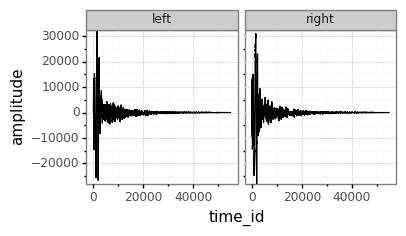

<ggplot: (8787347182393)>

In [20]:
(
    ggplot(bass_pd.melt(id_vars = ['time_id'], value_name='amplitude', var_name='stereo')) 
      + geom_line(aes(x = 'time_id', 
                      y = 'amplitude'))
      + facet_wrap('stereo') 
      + theme(figure_size=(4,2))
)

where we see the amplitudes of the left and right channel over time. To train the model we need to take a number of steps:

- Read the data into memory
- Construct features based on each drum sample
- Use crossvalidation to fit the regularisation strength

the `generate_drum_model.py` script on github performs all these steps and dumps the results to disc. In the next section we will pick up the crossvalidation results and construct a number of useful diagnostic plots. 

## Diagnostic plots
The basis for the diagnostic plots are the crossvalidation results generated using [`LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html):

In [21]:
#from sklearn.svm import l1_min_c
from joblib import dump, load

#cs = l1_min_c(audio_tsfresh, all_labels, loss='log') * np.logspace(0, 7, 16)
cv_result = load('pkl/drum_logreg_cv.joblib')

The main result in the crossvalidation object is the regularisation strength that was chosen, stored in the `C_` attribute:

In [22]:
np.log10(1/(2*cv_result.C_))

array([6.05011715, 6.05011715, 6.05011715])

note we transform the `C_` attribute here as `LogisticRegressionCV` from sklearn works with the inverse of the regularisation strength. I use the $\alpha$ definition that Lasso uses, which equals `1/2C`. I added the log transform to make the number more readable. 

### Plot A: Development of coefficients
In the crossvalidation procedure we used a L1-norm, which means that coefficients in the model get pushed to zero as the regularisation strength increases. To visualise this effect troughout the crossvalidation we make a plot using the `plot_coef_paths` that can be found in the `helper_functions.py` file on github: 

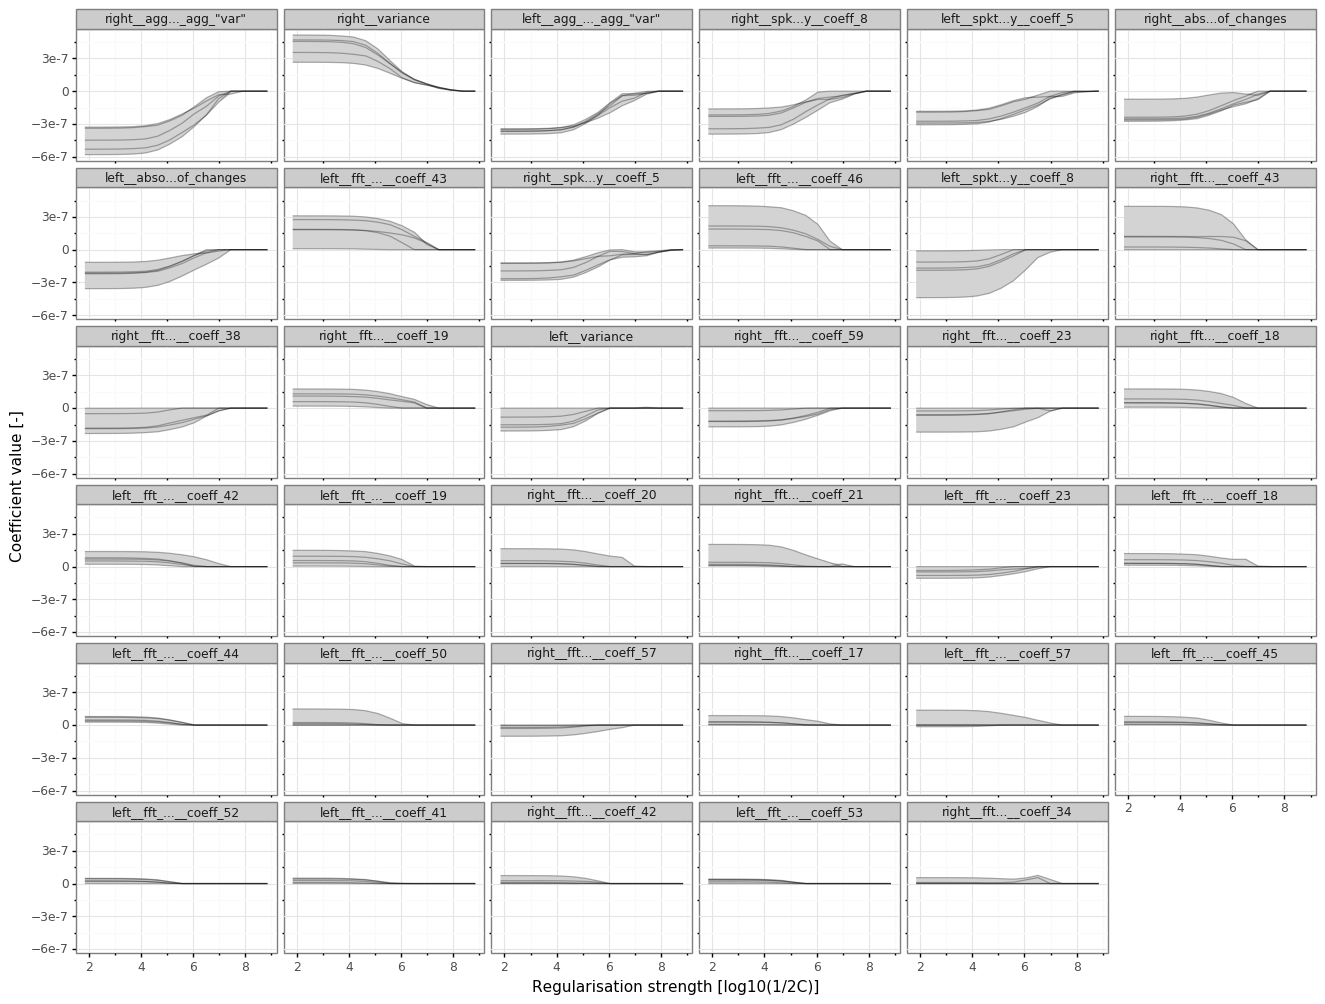

<ggplot: (8787340754269)>

In [23]:
plot_coef_paths(cv_result, 'kick', audio_tsfresh) + theme(figure_size=(16,12))

here we see how the coefficients for the `kick` model change for each feature when we increase the regularisation strength. Because we use a L1 norm, the coefficients are pushed all the way down to zero if we increase the regularisation strength enough. Note that for the selected strenght (~6) there is still variance between the 5 different crossvalidation folds, for some these values can vary significantly. 

In the following sections we will slowly deconstruct this plot and show how to make it. 

#### Step 1: wide to long data
The main source of data for this plot is the `coef_paths_` attribute of the result object from `LogisticRegressionCV`. This attribute stores a dictionary with an entry for each of the possible classes the model can predict: bass, kick and snare in our case. The values in the dictionary are `numpy.ndarray` objects, which in turn store all the coefficient values. The shape of the `ndarray` is:

In [24]:
cv_result.coefs_paths_['kick'].shape

(5, 16, 328)

for the `kick` model. The first axis are the folds of the crossvalidation, the second axis are the possible regularisation strenght options and the third axis are the possible features. 

Plotnine does not work on `ndarray` objects, but needs [a long format](https://www.theanalysisfactor.com/wide-and-long-data/#:~:text=In%20the%20long%20format%2C%20each,below%20in%20the%20long%20format.) where each row consists of a single coefficient value and their associated regularisation strength, coefficient name and model. [A very efficient way to generate this long format](https://stackoverflow.com/questions/36853594/easy-multidimensional-numpy-ndarray-to-pandas-dataframe-method) data frame based on a `ndarray` is to flatten the entire `ndarray` into a single column, and add a `MultiIndex` which shows to which fold, regularisation strength and feature the coefficient belongs. 

First we generate the single column array using `reshape`:

In [25]:
kick_model = cv_result.coefs_paths_['kick']
single_column_array = kick_model.reshape(kick_model.size, 1)
single_column_array.shape

(26240, 1)

Next we generate the appropriate `MultiIndex` using `pd.MultiIndex.from_product`:

In [26]:
# Read the training data used in the model
audio_tsfresh = pd.read_pickle('pkl/drum_tsfresh.pkl')

In [27]:
index = pd.MultiIndex.from_product([range(kick_model.shape[0]),                      # 0-4 folds (length 5)
                                    cv_result.Cs_,                                   # The regularisation strength values (length 16)
                                    list(audio_tsfresh.columns) + ['intercept']],    # The feature names, note we add `intercept` (length 328)
                                   names=['folds', 'reg_strength','feature_name'])   # The names of the nd array dimensions
index.shape

(26240,)

Note that the sizes in the nested list we pass to `pd.MultiIndex.from_product` exactly match the shape of the multidimensional array. Using this we know for each of the coefficients in the array to which (fold, regularisation strength, feature name) combo it belongs. 

Now we can combine these two:

In [31]:
plot_data = pd.DataFrame(single_column_array, index=index, columns=['coef_value']).reset_index()

Note we used `.reset_index()` here because we need the columns in the index as normal columns for plotting. 

Now we transformed the data from a multidimensional array to a flat table with all the values in the array in one column. The other columns now specify to which fold, strength and feature the coefficient belongs. In `helper_functions.py` you can find the function `ndarray_to_long` function which performs this operation.

#### Step 2: transform C to $\alpha$ and apply log
The logistic regression functions in sklearn work with the inverse of the regularisation strength. I find working with the regularisation strength directly more intuitive, and I use the $\alpha$ definition for regularisation strength used in the `Lasso` function in sklearn. In addition, I log transform the values to aid in readability of the plot as the values chosen for the regularisation strength follow a log distribution. For more details I refer to the `generate_drum_model.py` script on github. 

In [32]:
plot_data = plot_data.assign(reg_strength = np.log10(1/(2*plot_data["reg_strength"].astype('float'))))
plot_data

,folds,reg_strength,feature_name,coef_value
0,0,8.850117,left__absolute_sum_of_changes,0.000000e+00
1,0,8.850117,"right__agg_autocorrelation__f_agg_""median""__ma...",0.000000e+00
2,0,8.850117,right__autocorrelation__lag_9,0.000000e+00
3,0,8.850117,right__autocorrelation__lag_8,0.000000e+00
4,0,8.850117,right__cid_ce__normalize_True,0.000000e+00
...,...,...,...,...
26235,4,1.850117,"right__agg_linear_trend__attr_""slope""__chunk_l...",0.000000e+00
26236,4,1.850117,"left__change_quantiles__f_agg_""var""__isabs_Tru...",0.000000e+00
26237,4,1.850117,"left__agg_linear_trend__attr_""stderr""__chunk_l...",0.000000e+00
26238,4,1.850117,"right__agg_linear_trend__attr_""stderr""__chunk_...",0.000000e+00


#### Step 3: discard non-relevant features
Using tsfresh we generated 328 possible features for the model. Plotting all these 328 features in a plot including the development of their coefficients is simply too much. Therefore we only choose coefficients that have a mean coefficient size above a certain threshold. Here we choose a cutoff of `1e-8`:

In [33]:
coef_cutoff = '1e-8'
mean_coef_values = plot_data.groupby(['feature_name']).mean()
relevant_features = mean_coef_values.query('abs(coef_value) > %s' % coef_cutoff).index
plot_data = plot_data[plot_data['feature_name'].isin(relevant_features)]

Note the use of `abs(coef_value)` which ensures that we also include features that have negative coefficients. The exact 

#### Step 4: sort features from high to low coefficient value
In the plot we use a subplot for each of the possible features in a grid. We want to the most important feature to be in the top left corner of the grid. To get this working we need to apply a sorting to the feature names column. We do this using the `pd.Categorical` function:

In [34]:
coef_from_high_to_low = (
    plot_data.groupby(['feature_name'])
      .mean()
      .abs()
      .sort_values(by='coef_value', ascending=False)
      .index
)
plot_data['feature_name'] = pd.Categorical(plot_data['feature_name'], categories=coef_from_high_to_low)

where the category sorting is done by looking at the absolute (`.abs`) mean (`.mean`) coefficient value per feature (`.groupby(['feature_name']`). Actually sorting the values is done using `.sort_values`. Also note that we return the feature names and not the sorted coefficient values using `.index`. 

Important to remember here is that the actually values in `plot_data['feature_name']` are not sorted: the category order in the metadata is sorted.

#### Step 5: calculating min/max of the data
In the plot we use both a set of lines, one for each fold in the cross validation, and a ribbon which covers the min and max of the lines. We need to precompute this min max for later use in `plotnine`:

In [38]:
plot_data_min_max = plot_data.groupby(['reg_strength', 'feature_name']).agg(['min', 'max'])
plot_data_min_max

folds      \
                                                                  min max   
reg_strength feature_name                                                   
1.850117     right__agg_linear_trend__attr_"intercept"__chun...     0   4   
             right__variance                                        0   4   
             left__agg_linear_trend__attr_"intercept"__chunk...     0   4   
             right__spkt_welch_density__coeff_8                     0   4   
             left__spkt_welch_density__coeff_5                      0   4   
...                                                               ...  ..   
8.850117     left__fft_coefficient__attr_"abs"__coeff_52            0   4   
             left__fft_coefficient__attr_"abs"__coeff_41            0   4   
             right__fft_coefficient__attr_"abs"__coeff_42           0   4   
             left__fft_coefficient__attr_"abs"__coeff_53            0   4   
             right__fft_coefficient__attr_"abs"__coeff_34           0   4   

                                                                   coef_value  \
                                                                          min   
reg_strength feature_name                                                       
1.850117     right__agg_linear_trend__attr_"intercept"__chun... -5.813560e-07   
             right__variance                                     2.646393e-07   
             left__agg_linear_trend__attr_"intercept"__chunk... -3.935294e-07   
             right__spkt_welch_density__coeff_8                 -3.937117e-07   
             left__spkt_welch_density__coeff_5                  -3.078835e-07   
...                                                                       ...   
8.850117     left__fft_coefficient__attr_"abs"__coeff_52         0.000000e+00   
             left__fft_coefficient__attr_"abs"__coeff_41         0.000000e+00   
             right__fft_coefficient__attr_"abs"__coeff_42        0.000000e+00   
             left__fft_coefficient__attr_"abs"__coeff_53         0.000000e+00   
             right__fft_coefficient__attr_"abs"__coeff_34        0.000000e+00   

                                                                               
                                                                          max  
reg_strength feature_name                                                      
1.850117     right__agg_linear_trend__attr_"intercept"__chun... -3.289956e-07  
             right__variance                                     5.144502e-07  
             left__agg_linear_trend__attr_"intercept"__chunk... -3.452052e-07  
             right__spkt_welch_density__coeff_8                 -1.623742e-07  
             left__spkt_welch_density__coeff_5                  -1.841126e-07  
...                                                                       ...  
8.850117     left__fft_coefficient__attr_"abs"__coeff_52         0.000000e+00  
             left__fft_coefficient__attr_"abs"__coeff_41         0.000000e+00  
             right__fft_coefficient__attr_"abs"__coeff_42        0.000000e+00  
             left__fft_coefficient__attr_"abs"__coeff_53         0.000000e+00  
             right__fft_coefficient__attr_"abs"__coeff_34        0.000000e+00  

[560 rows x 4 columns]

Note that the use of `.agg` in combination with multiple input functions led to the inclusion of a `MultiIndex` on the columns. For plotting in `plotnine` I just wan to have a flat column name list. To flatten the `MultiIndex` I use:

In [ ]:
plot_data_min_max.columns = ['_'.join(col).strip() for col in plot_data_min_max.columns.values] 

where I join all the levels in the `MultiIndex` using an `_`. Finally I get rid of the row index as I want the columns available for use in `plotnine`:

In [ ]:
plot_data_min_max = plot_data_min_max.reset_index()

#### Step 6: plotting in plotnine
Now we have all of our data ready, we start to make the plot:

In [ ]:
(
    ggplot(plot_data) + 
      geom_ribbon(plot_data_min_max, aes(x='reg_strength', ymin='coef_value_min', ymax='coef_value_max'), fill='lightgrey') + 
      geom_line(aes(x='reg_strength', y='coef_value', group='folds'), alpha=0.3) + 
      facet_wrap('~ feature_name', labeller=abbreviate_label) + 
      labs(x='Regularisation strength [log10(1/2C)]', y='Coefficient value [-]')
)

Note here that I:

- use two geometries: a ribbon geometry based on the min and max of the data and a line geometry for the individual folds in the crossvalidation. 
- the ribbon geom has its own data (`plot_data_min_max`) and does not use the main plot data (`plot_data`). This is useful as the ribbon geometry does not use all the raw data for each fold, but just the min and max of the data. 
- use an alpha of 0.3 on the lines. This ensures that they do not dominate the plot, and that we can spot overlapping lines. 
- use a custom label function in `facet_wrap`. The feature names that are generated by tsfresh are really big, too big to fit in the title box of a facet. To mitigate this issue I use a custom label function: `abbreviate_label` from `helper_functions.py`. For really long labels this takes the head and tail of the string and connects them using `...`. This greatly improves the readability of the facet labels. 
- using `( )` around the code. This is to be able to use newlines without having to include `\` each time. 

### Plot B: overall performance versus regularisation strength